In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, Printf, LaTeXStrings

In [3]:
FILE_F_MAP = "../test/datatest/F_REFERENCE.txt"
FILE_PS = "../test/datatest/file_pk.txt"
FILE_BACKGROUND = "../test/datatest/WideA_ZA_background.dat"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70,
    N = 1024, fit_min = 0.05, fit_max= 0.5, con=true)

cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP; expand=false)

GaPSE.parameters_used(stdout, cosmo)

I take the input power spectrum as it is,without expanding.
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "../test/datatest/file_pk.txt"
# F window function input file : "../test/datatest/F_REFERENCE.txt"
# CLASS Background input file: "../test/datatest/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001465757 Mpc/h_0
# 	 comoving s_max = 571.7022420258767 Mpc/h_0
# 	 comoving s_eff = 435.3747095690664 Mpc/h_0
# 	 comoving z_eff = 0.15045636096023224 
# 	 Volume of the survey V_survey = 3.845366167995967e8
# 	 σ_0 = 15.593462966741178
# 	 σ_1 = 15.074895881392285
# 	 σ_2 = 100.85852368830221
# 	 σ_3 = 3735.1227501923527
# 


In [4]:
IMPLEMENTED_GR_EFFECTS = [
     "auto_doppler", "auto_lensing",
     "auto_localgp", "auto_integratedgp",

     "lensing_doppler", "doppler_lensing",
     "doppler_localgp", "localgp_doppler",
     "doppler_integratedgp",  "integratedgp_doppler",
     "lensing_localgp", "localgp_lensing",
     "lensing_integratedgp",  "integratedgp_lensing",
     "localgp_integratedgp", "integratedgp_localgp",
];

ξs_names = [
    L"$\xi^{v_{\parallel} \, v_{\parallel}}$", 
    L"$\xi^{\kappa \, \kappa}$", 
    L"$\xi^{\phi \, \phi}$", 
    L"$\xi^{\int\phi \, \int\phi}$", 
    
    L"$\xi^{\kappa \, v_{\parallel}}$",
    L"$\xi^{v_{\parallel} \, \kappa}$",
    
    L"$\xi^{v_{\parallel} \, \phi}$",
    L"$\xi^{\phi \, v_{\parallel}}$",
    
    L"$\xi^{v_{\parallel} \, \int\phi}$",
    L"$\xi^{\int\phi \, v_{\parallel}}$",
    
    L"$\xi^{\kappa \, \phi}$",
    L"$\xi^{\phi \, \kappa}$",
    
    L"$\xi^{\kappa \, \int\phi}$",
    L"$\xi^{\int\phi \, \kappa}$",
    
    L"$\xi^{\phi \, \int\phi}$",
    L"$\xi^{\int\phi \, \phi}$",
]

INDEX_GR_EFFECT = Dict([name => i for (i, name) in 
            enumerate(IMPLEMENTED_GR_EFFECTS)]...);
GR_EFFECT_INDEXED = Dict([i => name for (i, name) in 
            enumerate(IMPLEMENTED_GR_EFFECTS)]...);

In [49]:
effect = "lensing_doppler";
LIM_MULTIPOLE = 4;
l = @layout [A{0.05h}; a ; b c ; d e ];

In [50]:
my_path = "ALL_Multipoles_files/"
my_files = my_path .* [
    "xi_"* effect * "_L"* "$L" * ".txt" for L in 0:LIM_MULTIPOLE];

my_dict =  Dict([k => v for (k, v) in 
            zip(IMPLEMENTED_GR_EFFECTS, my_files)]...);

In [62]:
kwargs = Dict(
    :enhancer => 1e25, :N_μs => 30, :μ_atol => 0.0, :μ_rtol => 1e-2,
    :en => 1e6, :N_χs => 50, #Δχ_min = 1e-4, 
    );

for i in 0:(LIM_MULTIPOLE)
    GaPSE.print_map_ξ_multipole(
        cosmo, 
        "ALL_Multipoles_files/xi_"*effect*"_L$i" * ".txt", 
        effect; 
        use_windows = false, L = i,
        kwargs...
    )
end

lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:11
lensing_doppler, L=1: 100%|█████████████████████████████| Time: 0:00:10
lensing_doppler, L=2: 100%|█████████████████████████████| Time: 0:00:11
lensing_doppler, L=3: 100%|█████████████████████████████| Time: 0:00:13
lensing_doppler, L=4: 100%|█████████████████████████████| Time: 0:00:16



time needed for map_integral_on_mu for lensing_doppler [in s] = 11.47014 

time needed for map_integral_on_mu for lensing_doppler [in s] = 10.61190 

time needed for map_integral_on_mu for lensing_doppler [in s] = 11.00447 

time needed for map_integral_on_mu for lensing_doppler [in s] = 13.56940 

time needed for map_integral_on_mu for lensing_doppler [in s] = 16.14641 


In [63]:
my_all_table = [readdlm(file, comments=true) for file in my_files]
my_all_ss = [convert(Vector{Float64}, t[:,1]) for t in my_all_table];
my_all_ξs = [convert(Vector{Float64}, t[:,2]) for t in my_all_table];

In [72]:
mattia_effect =  "lensing_doppler";
mattia_path = "../MATTIA_OUTPUTS/"
mattia_files = mattia_path .* [
    "xi_"* mattia_effect * "_L"* "$L" * ".txt" for L in 0:LIM_MULTIPOLE];

mattia_dict =  Dict([k => v for (k, v) in 
            zip(IMPLEMENTED_GR_EFFECTS, mattia_files)]...);

mattia_all_table = [readdlm(file) for file in mattia_files]
mattia_all_ss = [convert(Vector{Float64},t[2:end,1]) for t in mattia_all_table];
mattia_all_ξs = [convert(Vector{Float64},t[2:end,2]) for t in mattia_all_table];

In [77]:
casto_table = readdlm("../test/datatest/tab_kappa_terms.dat")
casto_ss = convert(Vector{Float64}, casto_table[3:end, 1]);
casto_all_auto_lensings = [
    convert(Vector{Float64}, casto_table[3:end, i]) 
    for i in 2:6];

enea_effect = "kappas1_dopplers2"
enea_path = "/Users/matteofoglieni/Dropbox/GR_effects/Enea_Output/"
enea_files = enea_path .* [
    "xi_"* enea_effect * "_L$L" * "_zeff_015.dat" for L in 0:LIM_MULTIPOLE
        ];
enea_all_table = [readdlm(file) for file in enea_files]
enea_all_ss = [convert(Vector{Float64}, t[:,1]) for t in enea_all_table];
enea_all_ξs = [convert(Vector{Float64}, t[:,2]) for t in enea_all_table];

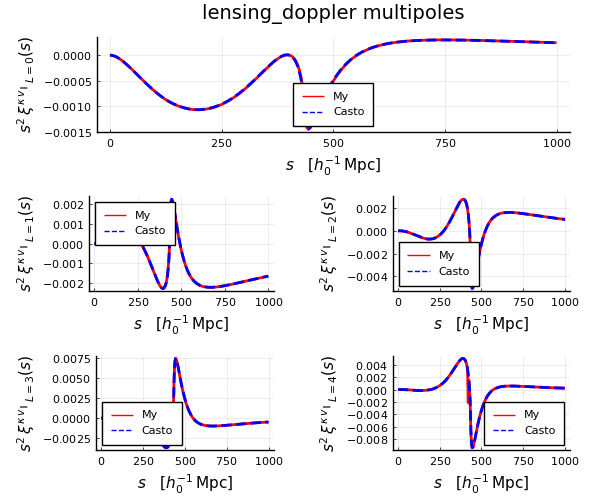

In [81]:
pyplot()
ps = [plot() for i in 0:LIM_MULTIPOLE]

title = plot(title = effect * " multipoles", grid=false, 
    showaxis = false, bottom_margin = -20Plots.px, ticks=false)

legend_pos_norm=[:bottomleft, :topright, :bottomleft, :bottomleft, :topleft,]

legend_pos_square=[ :bottom, :topleft, :bottomleft, :bottomleft, :bottomright, ]

for i in 1:(LIM_MULTIPOLE+1)
    my_xs = my_all_ss[i]
    my_ys = my_all_ξs[i] .* my_xs .^2
    
    #ot_xs = mattia_all_ss[i]
    #ot_ys = mattia_all_ξs[i]
    ot_xs = enea_all_ss[i]
    ot_ys = enea_all_ξs[i]
    
    L=i-1
    ps[i] = plot(
        #my_xs, my_ys .* my_xs .^2,
        [my_xs, ot_xs], 
        [my_ys, ot_ys],
        size=(300, 100),
        lw=2, lc=["red" "blue"], ls=[:solid :dash],
        label = ["My" "Casto"],
        legend=legend_pos_square[i],
        xlabel = L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
        ylabel = L"s^2 \, " * ξs_names[INDEX_GR_EFFECT[effect]] * L"_{L=%$L}(s)",
        #xaxis=:log,
        top_margins=15Plots.px,
        #yaxis=nothing,
        #yaxis=:log,
    )
end

P = plot(title, ps..., layout=l, 
    left_margins = 15Plots.px, right_margins = 30Plots.px,
    size=(600,500))

In [57]:
#=
i = 5

my_xs = my_all_ss[INDEX_GR_EFFECT[effect]]
xs = mattia_all_ss[INDEX_GR_EFFECT[effect]]

my_ys = my_all_ξs[INDEX_GR_EFFECT[effect]] 
ys = mattia_all_ξs[INDEX_GR_EFFECT[effect]]
spline = Spline1D(xs, ys)

S_VLIM = cosmo.s_eff
S_VLIM_F = @sprintf("%.2f", S_VLIM)

pyplot()
p1 = plot(
    [my_xs, xs], 
    [my_ys .* my_xs .^2, ys .* xs .^2], 
    #xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], 
    label=["My" "Mattia"], title=effect,
    ylabel=L"$s^2 \;$" * ξs_names[INDEX_GR_EFFECT[effect]],
    ls=[:dash :solid], legend=legend_pos_square[INDEX_GR_EFFECT[effect]])
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(my_xs, spline.(my_xs) ./ my_ys, lc=:green, #xaxis=:log,
    ylim=(0.99,1.01), legend=false, ylabel="ratio",
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 400), layout= @layout [ x ; z ] )
#savefig(P, "xi_"*"$effect"*"_L0.pdf")
#display(P)
=#

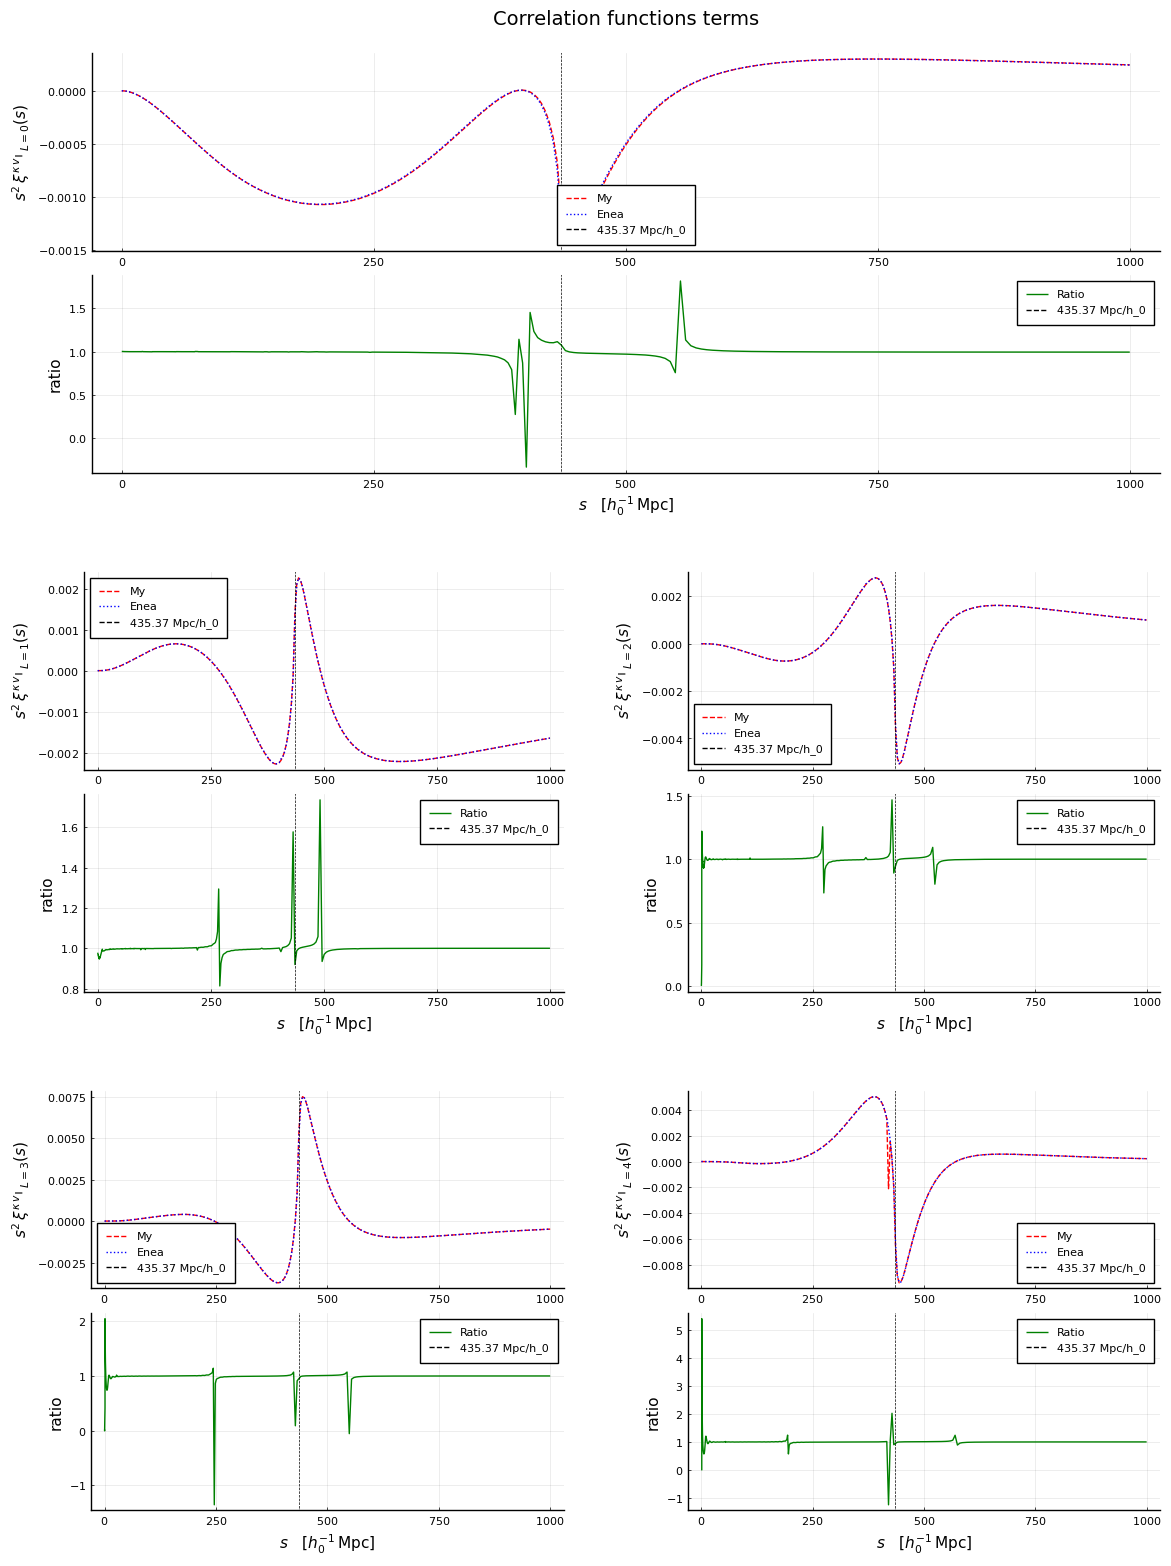

In [86]:
pyplot()

title = plot(title = "Correlation functions terms", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

LIST_P = [plot() for i in 0:LIM_MULTIPOLE]
for i in 1:(LIM_MULTIPOLE+1)
    tit = "\n\n"*effect
    
    my_xs = my_all_ss[i]
    my_ys = my_all_ξs[i] .* my_xs.^2
    
    #ot_xs = mattia_all_ss[i]
    #ot_ys = mattia_all_ξs[i] .* xs.^2
    ot_xs = enea_all_ss[i]
    ot_ys = enea_all_ξs[i]
    
    spline = Spline1D(ot_xs, ot_ys)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[my_xs[my_ys.>0], ot_xs[ot_ys.>0]], 
        #[my_ys[my_ys.>0],  ot_ys[ot_ys.>0]], 
        [my_xs, ot_xs], 
        [my_ys,  ot_ys], 
        #xaxis=:log, yaxis=:log, 
        lc=[:red :blue], 
        label=["My" "Enea"], 
        ylabel=L"s^2 \," * ξs_names[INDEX_GR_EFFECT[effect]] * L"_{L=%$(i-1)} (s)",
        ls=[:dash :dot], legend=legend_pos_square[i])
    vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

    p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", 
        lc=:green, #xaxis=:log,
        #ylim=(0.99,1.01), legend=:false,
        bottom_margins= 50Plots.px,
        ylabel="ratio",
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 25Plots.px, right_margins = 25Plots.px, size=(1200,1600))
savefig(ALL_PLOTS, "ALL_Multipoles_"*effect*".pdf")
#display(ALL_PLOTS)